## Top 1 Top5 and Top 10 accuracies for 101 classes

##### Random seed for 5-Fold

In [1]:
SEED = 42
from random import seed as py_seed
py_seed(SEED)
from numpy.random import seed as np_seed
np_seed(SEED)
from tensorflow import random as tf_random
tf_random.set_seed(SEED)

In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import np_utils
from keras.models import load_model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import random
from sklearn.model_selection import KFold, train_test_split
import pickle
import functools
from keras import backend as K
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
### Read 101 categories and randomely select 25 categories. Read data only from those folders. 

In [4]:
# Data comes from here. This should contain a bunch of folders of classes, each containing examples
#DATA_PATH = Path('food-101-original-source/images')
DATA_PATH = Path('images')
SAVE_PATH = '101_runs/'

# Get class (folder) names
classes = sorted([entry.name for entry in DATA_PATH.iterdir() if entry.is_dir()])

# Load list of filenames and classes, and convert to numpy array to allow array slicing
# For k-fold validation
dataset = np.array([
    (f"{clazz}/{entry.name}", clazz)
    for clazz in classes
    for entry in (DATA_PATH / clazz).iterdir()
])

#### Class labels

In [5]:
# Classes
print(classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nacho

In [6]:
# create data generators

# Rescale 0-255 to 0-1
RESCALE=1./255

# This type of data generator is used to train the model
train_datagen = ImageDataGenerator(
    rescale=RESCALE,
    # Factors used to control
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.125,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.125,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
)

# This type of generator is used to test the model
test_datagen = ImageDataGenerator(
    rescale=RESCALE,
)

### Function for Top 10 accuracy

In [7]:
top10_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=10)
top10_acc.__name__ = 'top10_acc'

In [8]:
# model function
def create_model(input_shape, num_classes):
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(input_shape, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = RMSprop()

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy','top_k_categorical_accuracy',top10_acc] # top1, top5 and top10 accuracies
    )
    
    return model


In [9]:
# Image data generator settings
TARGET_SIZE = (224,224)
COLOR_MODE = "rgb"
BATCH_SIZE = 64
CLASS_MODE = "categorical"


# Training settings
NUM_FOLDS = 5
VALIDATION_SPLIT = 0.1
NUM_EPOCHS = 5

# Model settings
kf = KFold(n_splits=NUM_FOLDS, random_state=SEED, shuffle=True)
results = []
cur_fold = 1

# saving classes used by this model
with open(SAVE_PATH+'classes_101.txt', 'w') as f:
    f.writelines("%s\n" % clss for clss in classes)


for train_index, test_index in kf.split(dataset):
    # Print a message
    print(f"Fold {cur_fold} of {NUM_FOLDS}")
    cur_fold += 1
    
    # Extract train dataset
    d_train = dataset[train_index]
    # Split train dataset to form train and validation dataset
    d_train, d_val = train_test_split(dataset, test_size = VALIDATION_SPLIT)
    
    # These are used to convert the filename,class pairs to dataframes
    FILENAME_COL = "filename"
    CLASS_COL = "class"
    COLUMNS = [FILENAME_COL, CLASS_COL]
    # Convert to dataframes
    d_train = pd.DataFrame(d_train, columns = COLUMNS)
    d_val = pd.DataFrame(d_val, columns = COLUMNS)
    
    # Create training data generators
    # Training image data generator
    train_it = train_datagen.flow_from_dataframe(
        d_train,
        directory = DATA_PATH,
        x_col = FILENAME_COL,
        y_col = CLASS_COL,
        target_size = TARGET_SIZE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        class_mode = CLASS_MODE,
        shuffle = True,
        seed = SEED
    )
    # Validation image data generator
    val_it = test_datagen.flow_from_dataframe(
        d_val,
        directory = DATA_PATH,
        x_col = FILENAME_COL,
        y_col = CLASS_COL,
        target_size = TARGET_SIZE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        class_mode = CLASS_MODE,
        shuffle = False,
    )
    
    # Perform training
    # Build the model
    input_shape = (*TARGET_SIZE,3)
    num_classes = len(classes)
    model = create_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_it,
        validation_data=val_it,
        epochs=NUM_EPOCHS,
        workers=6,
        max_queue_size=100,
        verbose=True
    )
    
    # Extract test dataset and convert to dataframe
    d_test = pd.DataFrame(dataset[test_index], columns = COLUMNS)
    # Create test image data generator
    test_it = test_datagen.flow_from_dataframe(
        d_test,
        directory = DATA_PATH,
        x_col = FILENAME_COL,
        y_col = CLASS_COL,
        target_size = TARGET_SIZE,
        color_mode = COLOR_MODE,
        batch_size = BATCH_SIZE,
        class_mode = CLASS_MODE,
        shuffle = False,
    )
    # Save history to a file 
    with open(SAVE_PATH+"history_101_"+str(cur_fold-1)+".pkl", 'wb') as file:
        pickle.dump(history, file)   
        
    # saving labels to a file (y_test)
    with open(SAVE_PATH+"y_test_101_"+str(cur_fold-1)+".pkl", 'wb') as file:
        pickle.dump(test_it.classes, file)

    # predict model
    y_predict = model.predict(test_it)
    
    # save it to a file (Y_predict)
    with open(SAVE_PATH+"y_predict_101_"+str(cur_fold-1)+".pkl", 'wb') as file:
        pickle.dump(y_predict, file)
     # Test
    fold_results = model.evaluate(test_it)
    results.append(fold_results)
    print(f"Results for current fold: {fold_results}")

Fold 1 of 5


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 89479 validated image filenames belonging to 100 classes.
Found 9943 validated image filenames belonging to 100 classes.
Epoch 1/5
1399/1399 [==============================] - 3003s 2s/step - loss: 3.3422 - accuracy: 0.2348 - top_k_categorical_accuracy: 0.4708 - top10_acc: 0.5955 - val_loss: 2.8702 - val_accuracy: 0.3037 - val_top_k_categorical_accuracy: 0.5915 - val_top10_acc: 0.7301
Epoch 2/5
1399/1399 [==============================] - 3173s 2s/step - loss: 2.9338 - accuracy: 0.3138 - top_k_categorical_accuracy: 0.5845 - top10_acc: 0.7078 - val_loss: 2.7024 - val_accuracy: 0.3119 - val_top_k_categorical_accuracy: 0.6044 - val_top10_acc: 0.7354
Epoch 3/5
1399/1399 [==============================] - 3356s 2s/step - loss: 2.8999 - accuracy: 0.3255 - top_k_categorical_accuracy: 0.5980 - top10_acc: 0.7211 - val_loss: 2.6345 - val_accuracy: 0.3270 - val_top_k_categorical_accuracy: 0.6117 - val_top10_acc: 0.7435
Epoch 4/5
1399/1399 [==============================] - 2922s 2s/step - l

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 19884 validated image filenames belonging to 100 classes.
311/311 [==============================] - 458s 1s/step
Results for current fold: [2.913503885269165, 0.34253671765327454, 0.6259806752204895, 0.7538221478462219]
Fold 2 of 5
Found 89479 validated image filenames belonging to 100 classes.
Found 9943 validated image filenames belonging to 100 classes.
Epoch 1/5
1399/1399 [==============================] - 2830s 2s/step - loss: 3.3379 - accuracy: 0.2330 - top_k_categorical_accuracy: 0.4716 - top10_acc: 0.5976 - val_loss: 2.8617 - val_accuracy: 0.2865 - val_top_k_categorical_accuracy: 0.5636 - val_top10_acc: 0.6952
Epoch 2/5
1399/1399 [==============================] - 2786s 2s/step - loss: 2.9326 - accuracy: 0.3134 - top_k_categorical_accuracy: 0.5839 - top10_acc: 0.7092 - val_loss: 2.8437 - val_accuracy: 0.3074 - val_top_k_categorical_accuracy: 0.5867 - val_top10_acc: 0.7222
Epoch 3/5
1399/1399 [==============================] - 2815s 2s/step - loss: 2.8932 - accuracy: 0.32

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 89479 validated image filenames belonging to 100 classes.
Found 9943 validated image filenames belonging to 100 classes.
Epoch 1/5
1399/1399 [==============================] - 2884s 2s/step - loss: 3.3438 - accuracy: 0.2355 - top_k_categorical_accuracy: 0.4708 - top10_acc: 0.5955 - val_loss: 3.1853 - val_accuracy: 0.2905 - val_top_k_categorical_accuracy: 0.5771 - val_top10_acc: 0.7069
Epoch 2/5
1399/1399 [==============================] - 2852s 2s/step - loss: 2.9306 - accuracy: 0.3135 - top_k_categorical_accuracy: 0.5837 - top10_acc: 0.7087 - val_loss: 3.1594 - val_accuracy: 0.3128 - val_top_k_categorical_accuracy: 0.5994 - val_top10_acc: 0.7279
Epoch 3/5
1399/1399 [==============================] - 2838s 2s/step - loss: 2.8966 - accuracy: 0.3281 - top_k_categorical_accuracy: 0.5989 - top10_acc: 0.7210 - val_loss: 3.2443 - val_accuracy: 0.3239 - val_top_k_categorical_accuracy: 0.6144 - val_top10_acc: 0.7408
Epoch 4/5
1399/1399 [==============================] - 2793s 2s/step - l

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 89479 validated image filenames belonging to 100 classes.
Found 9943 validated image filenames belonging to 100 classes.
Epoch 1/5
1399/1399 [==============================] - 2851s 2s/step - loss: 3.3481 - accuracy: 0.2332 - top_k_categorical_accuracy: 0.4681 - top10_acc: 0.5942 - val_loss: 3.4978 - val_accuracy: 0.2994 - val_top_k_categorical_accuracy: 0.5697 - val_top10_acc: 0.7044
Epoch 2/5
1399/1399 [==============================] - 3042s 2s/step - loss: 2.9424 - accuracy: 0.3128 - top_k_categorical_accuracy: 0.5805 - top10_acc: 0.7052 - val_loss: 3.6080 - val_accuracy: 0.3163 - val_top_k_categorical_accuracy: 0.5951 - val_top10_acc: 0.7253
Epoch 3/5
1399/1399 [==============================] - 2865s 2s/step - loss: 2.8890 - accuracy: 0.3292 - top_k_categorical_accuracy: 0.6004 - top10_acc: 0.7216 - val_loss: 3.9194 - val_accuracy: 0.3165 - val_top_k_categorical_accuracy: 0.5951 - val_top10_acc: 0.7249
Epoch 4/5
1399/1399 [==============================] - 3009s 2s/step - l

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 89479 validated image filenames belonging to 100 classes.
Found 9943 validated image filenames belonging to 100 classes.
Epoch 1/5
1399/1399 [==============================] - 2971s 2s/step - loss: 3.3381 - accuracy: 0.2350 - top_k_categorical_accuracy: 0.4719 - top10_acc: 0.5956 - val_loss: 3.0069 - val_accuracy: 0.2803 - val_top_k_categorical_accuracy: 0.5587 - val_top10_acc: 0.6977
Epoch 2/5
1399/1399 [==============================] - 2840s 2s/step - loss: 2.9322 - accuracy: 0.3140 - top_k_categorical_accuracy: 0.5833 - top10_acc: 0.7074 - val_loss: 2.9517 - val_accuracy: 0.3044 - val_top_k_categorical_accuracy: 0.5890 - val_top10_acc: 0.7182
Epoch 3/5
1399/1399 [==============================] - 2900s 2s/step - loss: 2.8994 - accuracy: 0.3262 - top_k_categorical_accuracy: 0.5978 - top10_acc: 0.7201 - val_loss: 2.9806 - val_accuracy: 0.3265 - val_top_k_categorical_accuracy: 0.6061 - val_top10_acc: 0.7349
Epoch 4/5
1399/1399 [==============================] - 2904s 2s/step - l

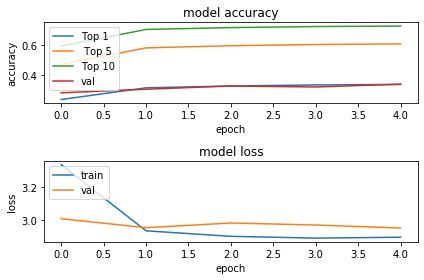

In [22]:
plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['top10_acc'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Top 1', ' Top 5','Top 10' , 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.show()

In [23]:
y_pred = []
for i in y_predict:
    y_pred.append(np.argmax(i, axis=0))

 Confusion Matrix 


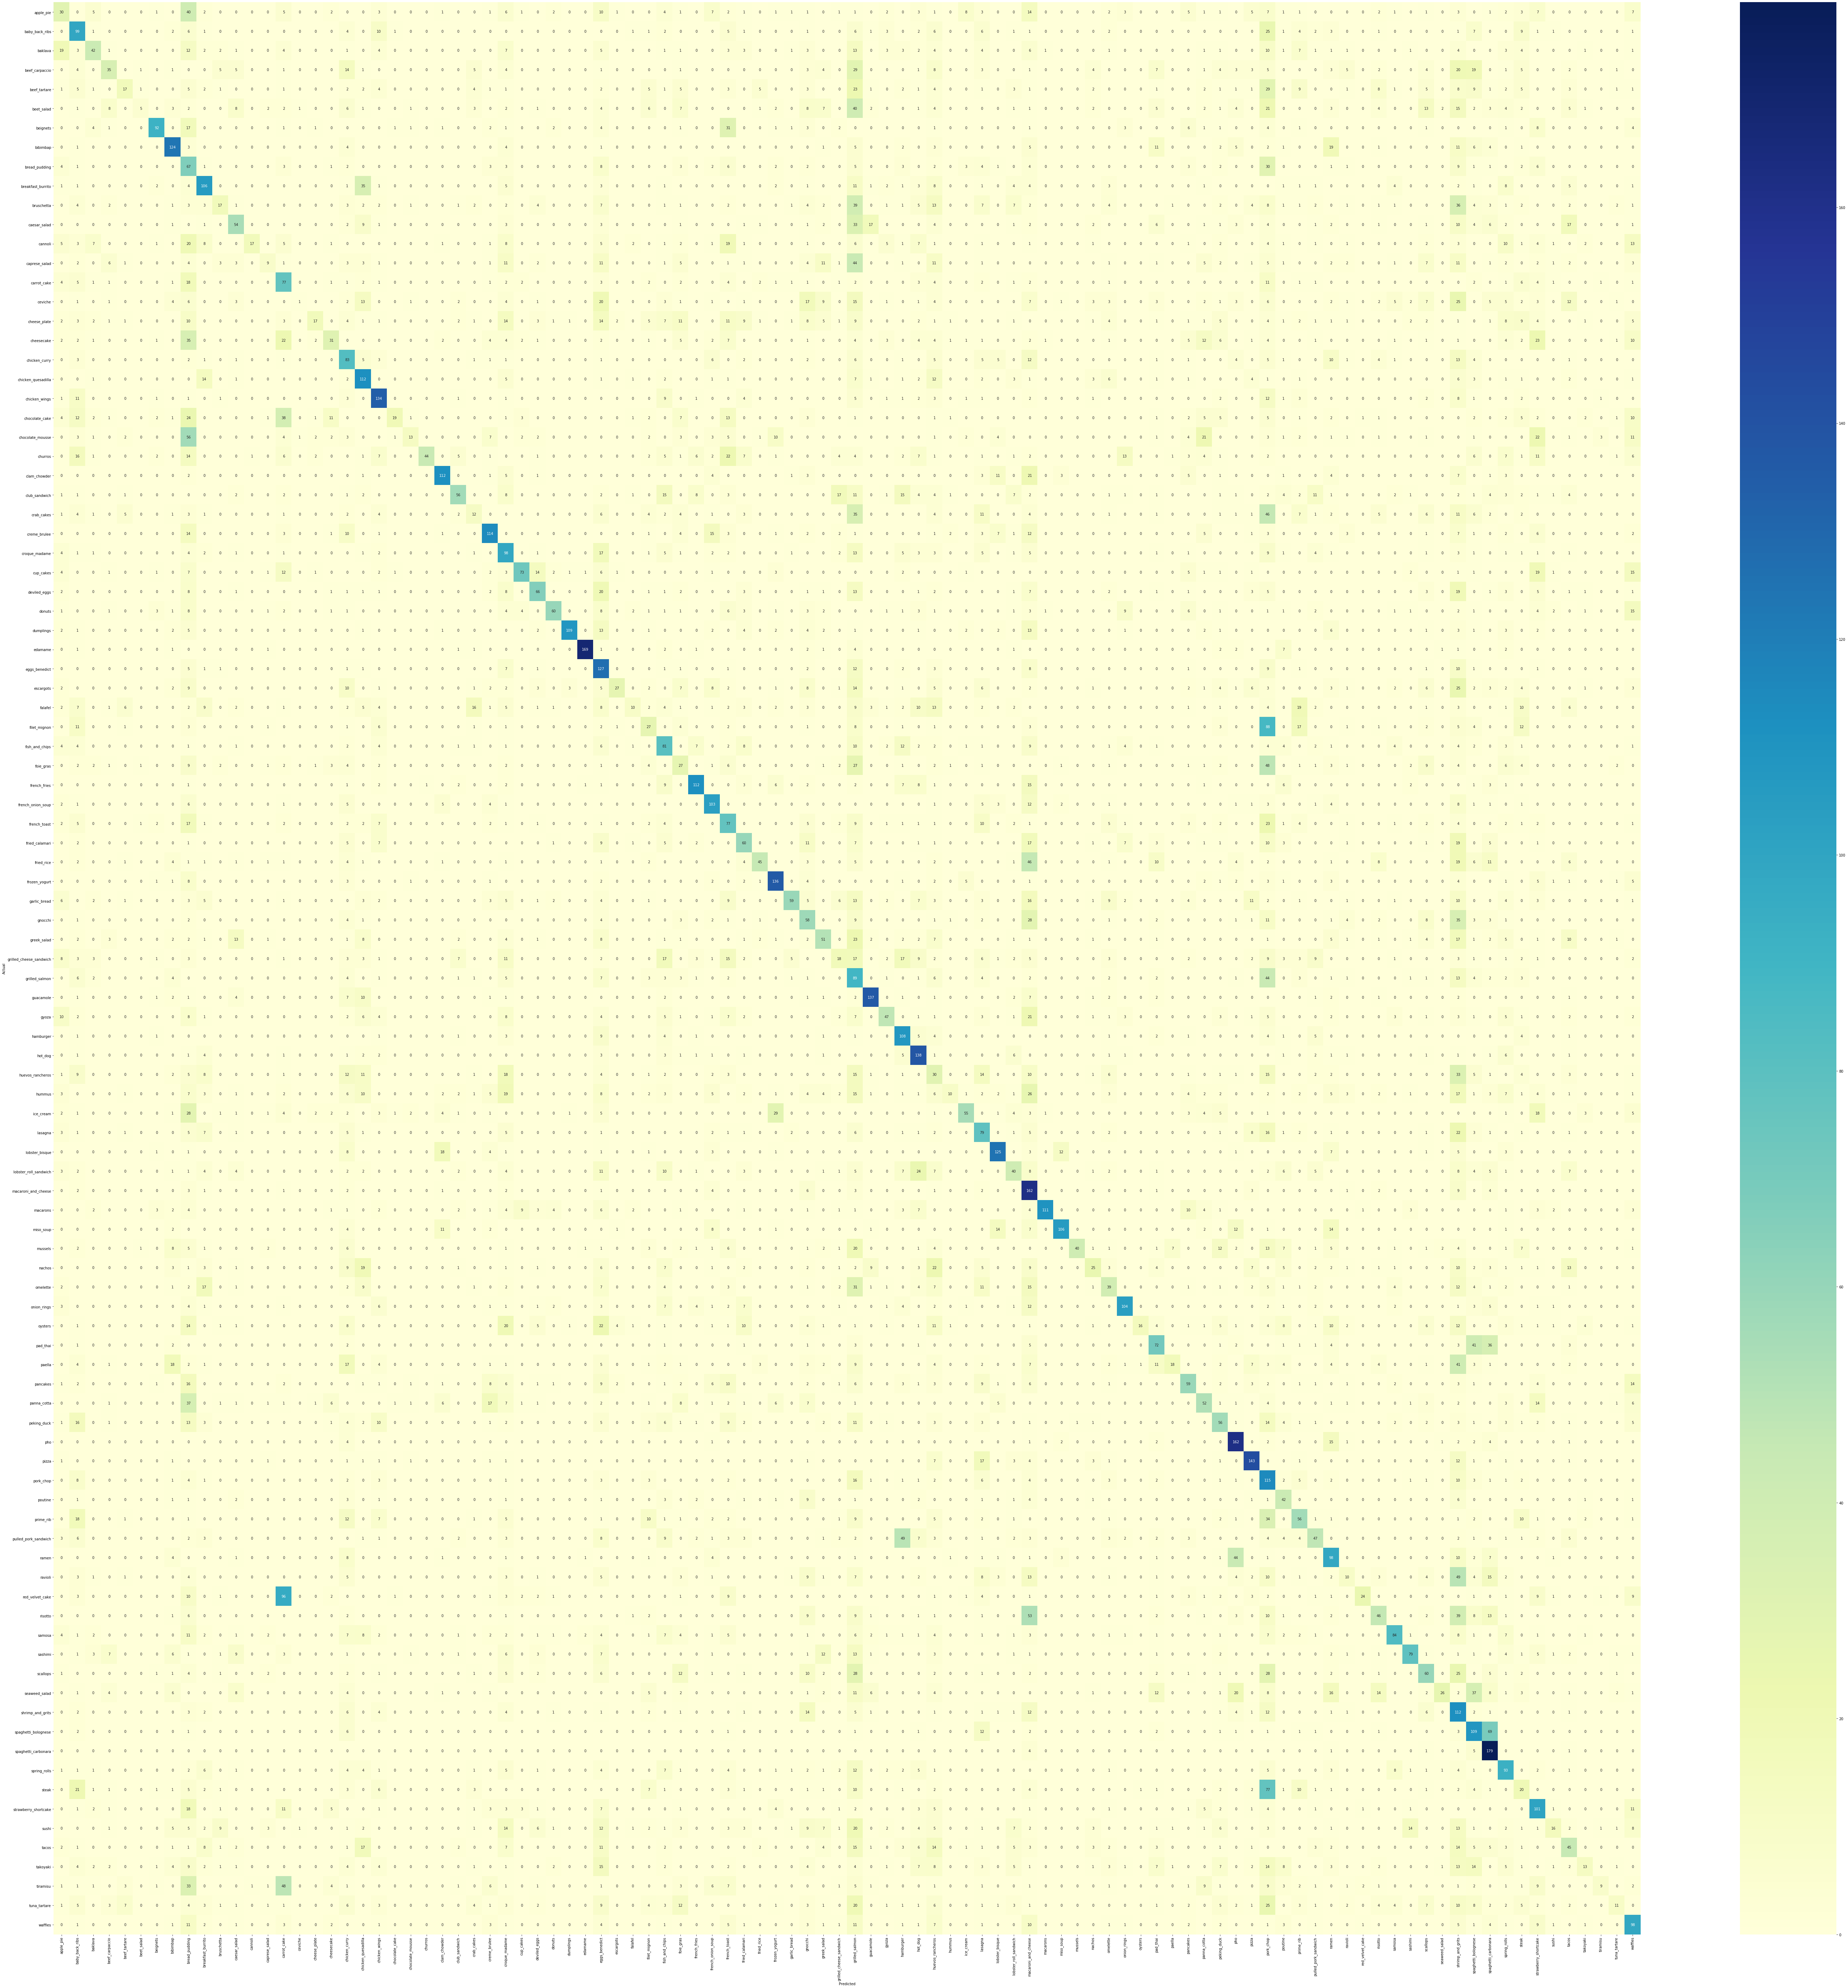

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
print(" Confusion Matrix ")
conf_mat = confusion_matrix(test_it.classes, y_pred)
fig, ax = plt.subplots(figsize=(101,101))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

results = confusion_matrix(test_it.classes, y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(test_it.classes, y_pred))
print ('Report : ')
print (classification_report(test_it.classes, y_pred))

SyntaxError: invalid syntax (<ipython-input-28-f6d37299271b>, line 9)